In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [3]:
# LeNet architecture

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1)
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = torch.tanh(self.pool1(x))
    x = torch.tanh(self.conv2(x))
    x = torch.tanh(self.pool2(x))
    x = torch.tanh(self.conv3(x))
    x = x.view(-1, 120) # flattening
    x = torch.tanh(self.fc1(x))
    x = self.fc2(x)   # output (logits)
    return x

model = LeNet5().to(device)

In [4]:
# data loading

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_data, val_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


In [5]:
# training loop

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(15):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Train Acc=0.3301, Val Acc=0.3738
Epoch 2: Train Acc=0.3990, Val Acc=0.4100
Epoch 3: Train Acc=0.4360, Val Acc=0.4378
Epoch 4: Train Acc=0.4582, Val Acc=0.4534
Epoch 5: Train Acc=0.4710, Val Acc=0.4596
Epoch 6: Train Acc=0.4838, Val Acc=0.4788
Epoch 7: Train Acc=0.4961, Val Acc=0.4742
Epoch 8: Train Acc=0.5043, Val Acc=0.4938
Epoch 9: Train Acc=0.5082, Val Acc=0.4966
Epoch 10: Train Acc=0.5204, Val Acc=0.5014
Epoch 11: Train Acc=0.5226, Val Acc=0.5166
Epoch 12: Train Acc=0.5336, Val Acc=0.5130
Epoch 13: Train Acc=0.5349, Val Acc=0.5254
Epoch 14: Train Acc=0.5418, Val Acc=0.5306
Epoch 15: Train Acc=0.5450, Val Acc=0.5158


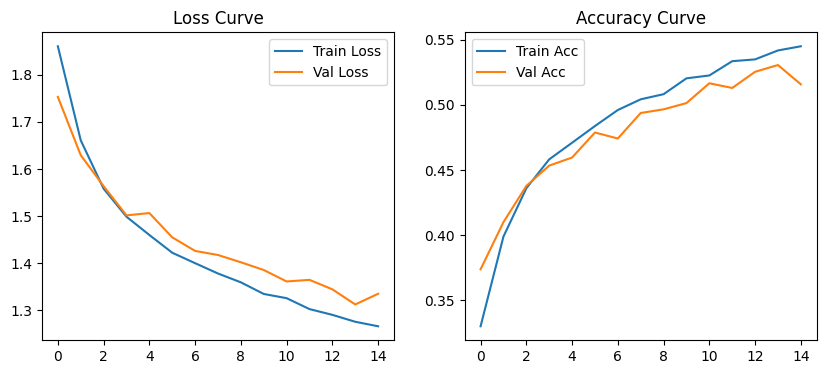

In [6]:
# loss curves

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [7]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


              precision    recall  f1-score   support

    airplane       0.57      0.64      0.61      1000
  automobile       0.60      0.76      0.67      1000
        bird       0.46      0.41      0.43      1000
         cat       0.47      0.21      0.29      1000
        deer       0.45      0.54      0.49      1000
         dog       0.47      0.49      0.48      1000
        frog       0.60      0.64      0.62      1000
       horse       0.62      0.66      0.64      1000
        ship       0.66      0.70      0.68      1000
       truck       0.65      0.53      0.58      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000



In [8]:
import seaborn as sns

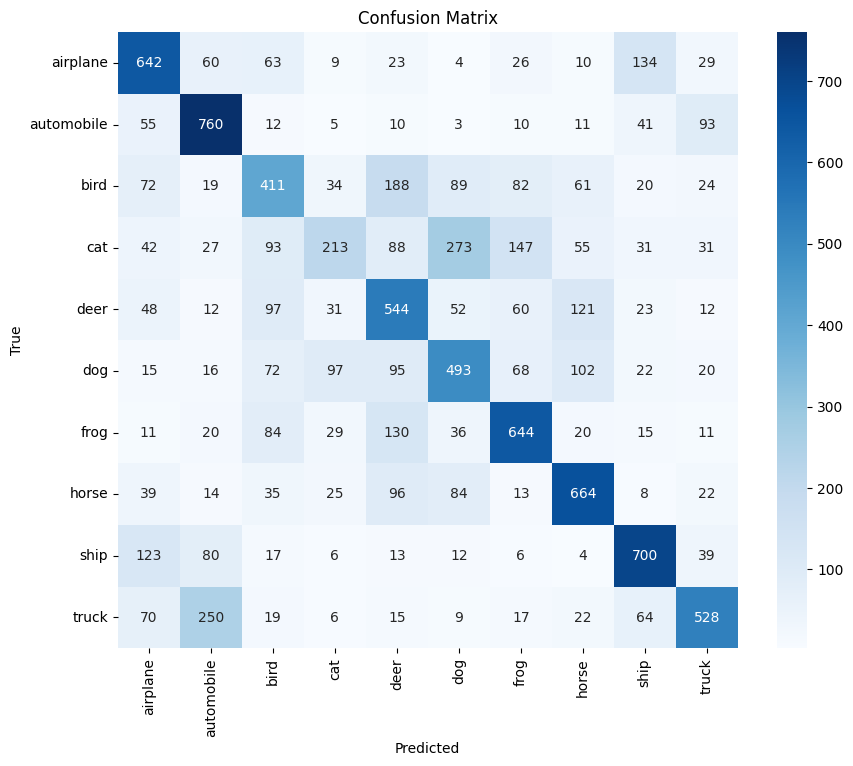

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()


In [10]:
torch.save(model.state_dict(), 'lenet5_cifar10.pth')

In [14]:
# loading the model
model = LeNet5()
model.load_state_dict(torch.load('lenet5_cifar10.pth', map_location=torch.device("cpu")))
model.to(device)

model.eval()
y_true, y_pred = [], []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs.cpu().numpy())
        preds = probs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


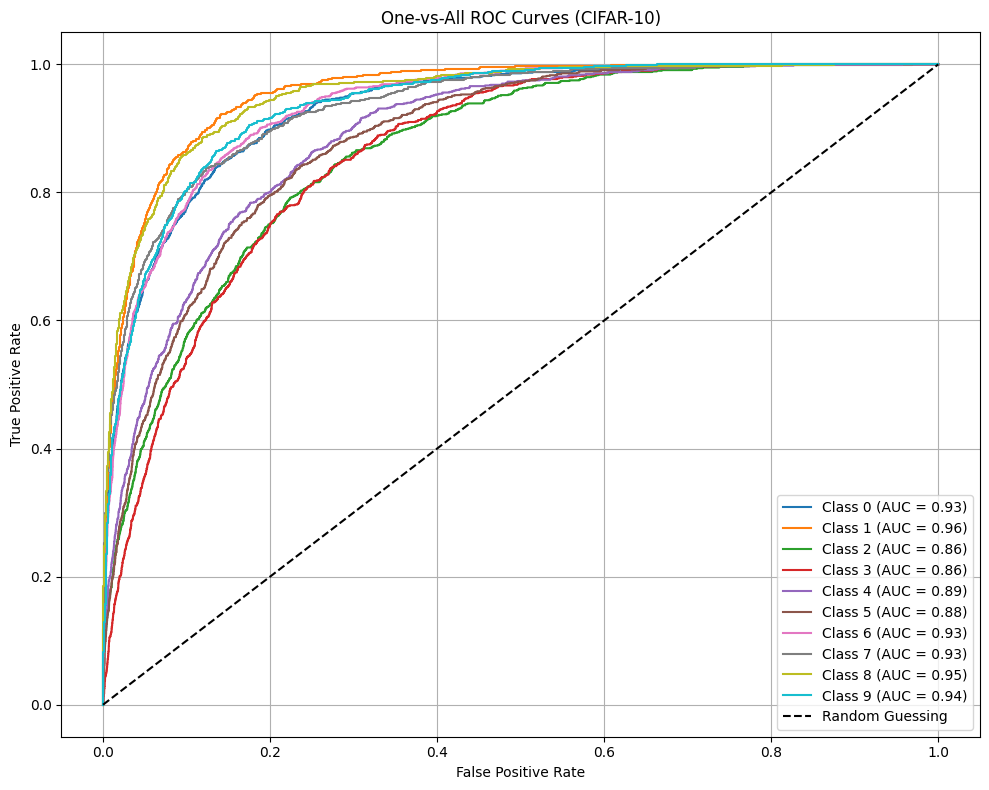

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 10

# Binarize labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # shape: (N, 10)
y_probs = np.array(y_probs)  # shape: (N, 10)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-All ROC Curves (CIFAR-10)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
